# Delta Hedging with Non-Constant Volatility Models

**Course**: 2025 Introduction to Quantitative Methods in Finance  
**Institute**: The Erdös Institute

## Project Overview

This project explores the impact of non-constant volatility on delta hedging strategies. Classical Black-Scholes delta hedging assumes constant volatility σ, but real markets exhibit time-varying volatility due to various factors including market sentiment, economic events, and volatility clustering.

### Objectives:
1. **Simulate stock paths** using different volatility models
2. **Implement delta hedging** for each model
3. **Compare profit distributions** across different volatility assumptions
4. **Analyze the impact** of stochastic volatility on hedging effectiveness

### Models Implemented:
- **Custom Sigma Model**: Random volatility selection at each time step
- **GARCH(1,1)**: Volatility clustering model
- **Heston Model**: Stochastic volatility with mean reversion
- **SABR Model**: Popular in interest rate and FX markets

## Mathematical Background

### Black-Scholes Framework

The European call option price under Black-Scholes:

$$C(S, K, \sigma, t, r) = S \cdot \Phi(d_1) - K e^{-rt} \cdot \Phi(d_2)$$

where:
$$d_1 = \frac{\ln(S/K) + (r + \frac{1}{2}\sigma^2)t}{\sigma \sqrt{t}}, \quad d_2 = d_1 - \sigma \sqrt{t}$$

The **delta** (price sensitivity):
$$\Delta = \frac{\partial C}{\partial S} = \Phi(d_1)$$

### Delta Hedging Strategy

- **Portfolio**: Short 1 call option, long Δ shares, cash position
- **Rebalancing**: Adjust share position to match current delta at each time step
- **Profit**: Final portfolio value minus initial option premium

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Load Functions

In [2]:
%run ./utils/hedging_utils.py

## Simulation and Analysis

In [3]:
np.random.seed(1205)

# Model parameters
S0 = 100        # Initial stock price
K = 100         # Strike price (at-the-money option)
T = 1.0         # Time to expiration (1 year)
N = 252         # Number of time steps (daily)
n_paths = 1000  # Number of simulation paths
mu = 0.08       # Drift parameter
r = 0.02        # Risk-free rate

print("=" * 60)
print("DELTA HEDGING WITH NON-CONSTANT VOLATILITY ANALYSIS")
print("=" * 60)
print(f"Parameters:")
print(f"  Initial Stock Price (S0): ${S0}")
print(f"  Strike Price (K): ${K}")
print(f"  Time to Expiration (T): {T} year")
print(f"  Time Steps (N): {N}")
print(f"  Simulation Paths: {n_paths}")
print(f"  Drift (μ): {mu:.1%}")
print(f"  Risk-free Rate (r): {r:.1%}")
print("=" * 60)

DELTA HEDGING WITH NON-CONSTANT VOLATILITY ANALYSIS
Parameters:
  Initial Stock Price (S0): $100
  Strike Price (K): $100
  Time to Expiration (T): 1.0 year
  Time Steps (N): 252
  Simulation Paths: 1000
  Drift (μ): 8.0%
  Risk-free Rate (r): 2.0%


## Model 1: Custom Sigma Model


1. CUSTOM SIGMA MODEL
----------------------------------------


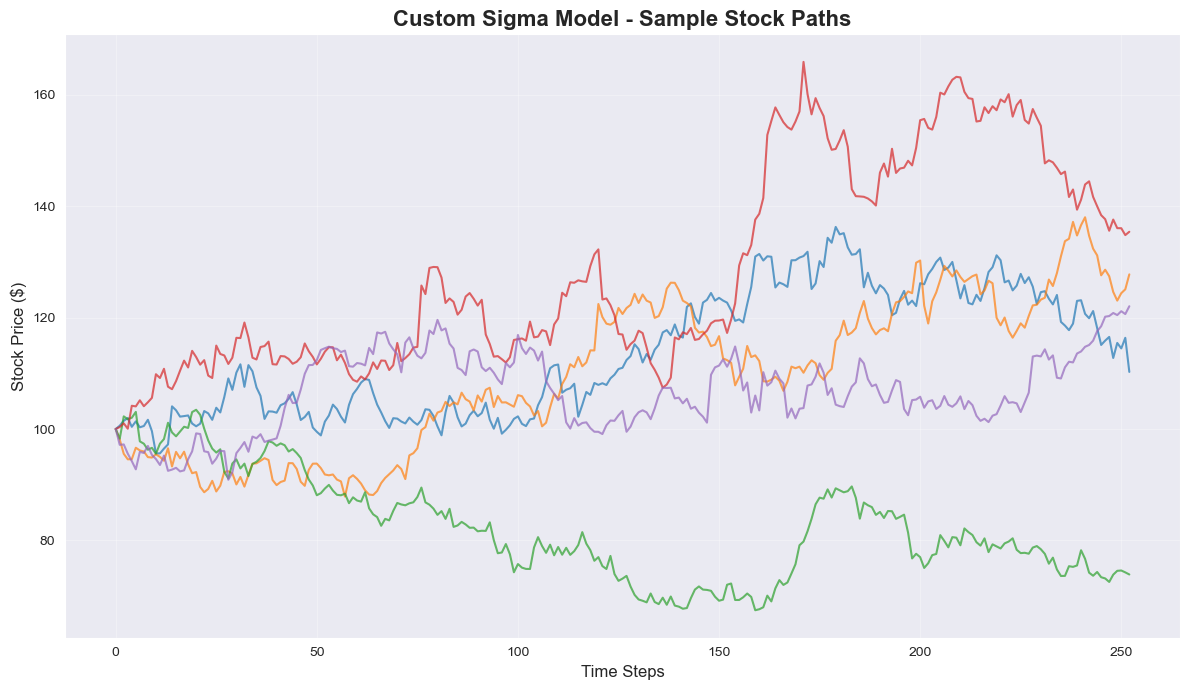

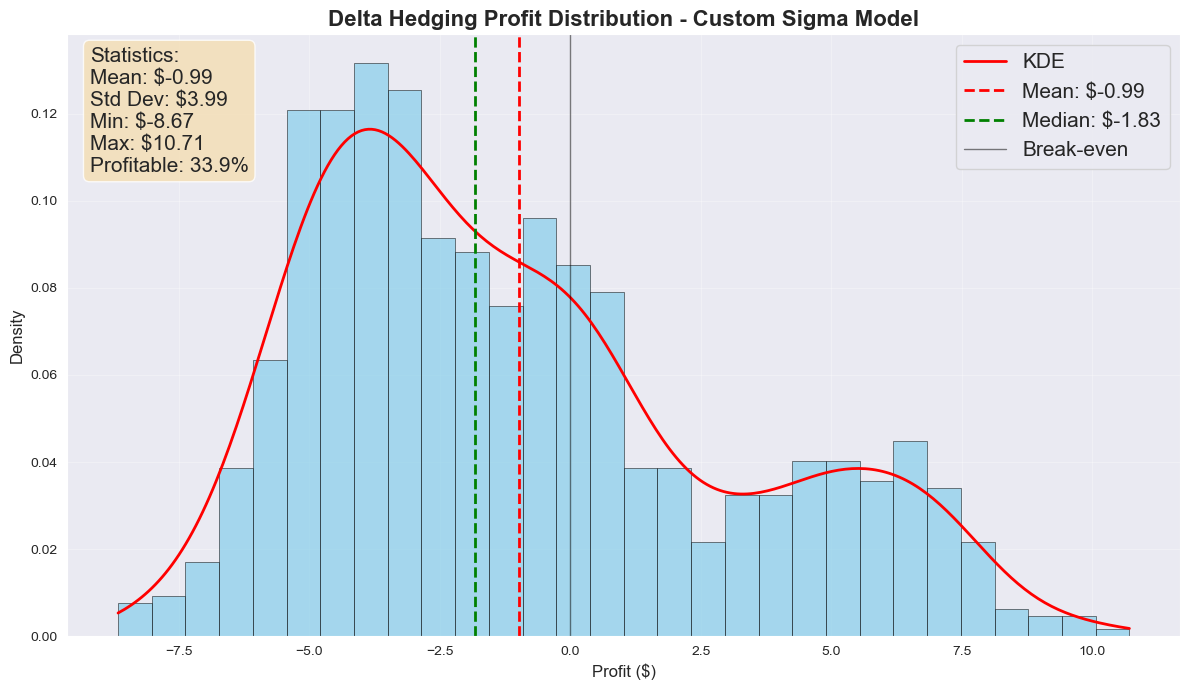

Custom Sigma Results:
  Mean Profit: $-0.99
  Std Deviation: $3.99
  Profitable Outcomes: 33.9%


In [6]:
print("\n1. CUSTOM SIGMA MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate custom sigma paths
custom_paths, custom_vols = simulate_custom_sigma_paths(
    S0=S0, mu=mu, r=r, T=T, N=N, n_paths=n_paths,
    sigma_choices=[0.2, 0.3, 0.45], sigma_probs=[0.5, 0.3, 0.2]
)

# Plot sample paths
plot_stock_paths(custom_paths, "Custom Sigma Model", n_display=5)

# Calculate hedging profits
custom_profits = delta_hedge_simulation(custom_paths, custom_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(custom_profits, "Custom Sigma Model")

print(f"Custom Sigma Results:")
print(f"  Mean Profit: ${np.mean(custom_profits):.2f}")
print(f"  Std Deviation: ${np.std(custom_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(custom_profits) > 0) / len(custom_profits) * 100:.1f}%")


2. GARCH(1,1) MODEL
----------------------------------------


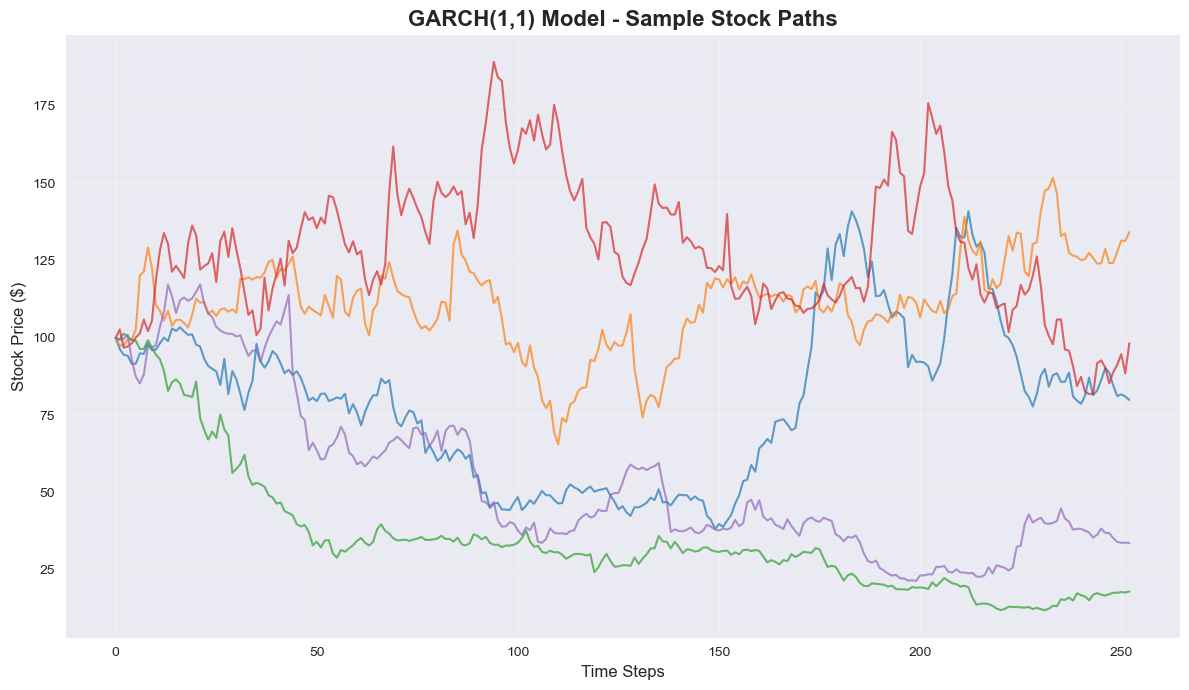

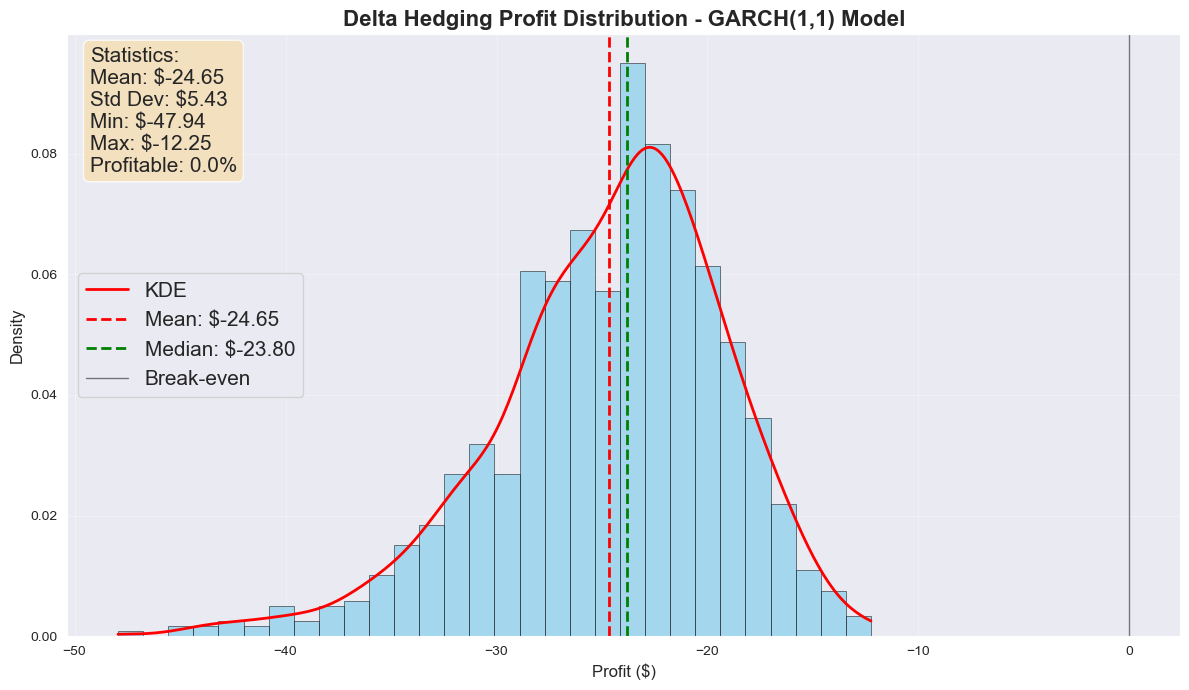

GARCH(1,1) Results:
  Mean Profit: $-24.65
  Std Deviation: $5.43
  Profitable Outcomes: 0.0%


In [5]:
print("\n2. GARCH(1,1) MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate GARCH paths
garch_paths, garch_vols = simulate_garch_paths(
    S0=S0, mu=mu, r=r, T=T, N=N, n_paths=n_paths,
    sigma0=0.2, omega=0.0001, alpha=0.1, beta=0.8
)

# Plot sample paths
plot_stock_paths(garch_paths, "GARCH(1,1) Model", n_display=5)

# Calculate hedging profits
garch_profits = delta_hedge_simulation(garch_paths, garch_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(garch_profits, "GARCH(1,1) Model")

print(f"GARCH(1,1) Results:")
print(f"  Mean Profit: ${np.mean(garch_profits):.2f}")
print(f"  Std Deviation: ${np.std(garch_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(garch_profits) > 0) / len(garch_profits) * 100:.1f}%")


3. HESTON STOCHASTIC VOLATILITY MODEL
----------------------------------------


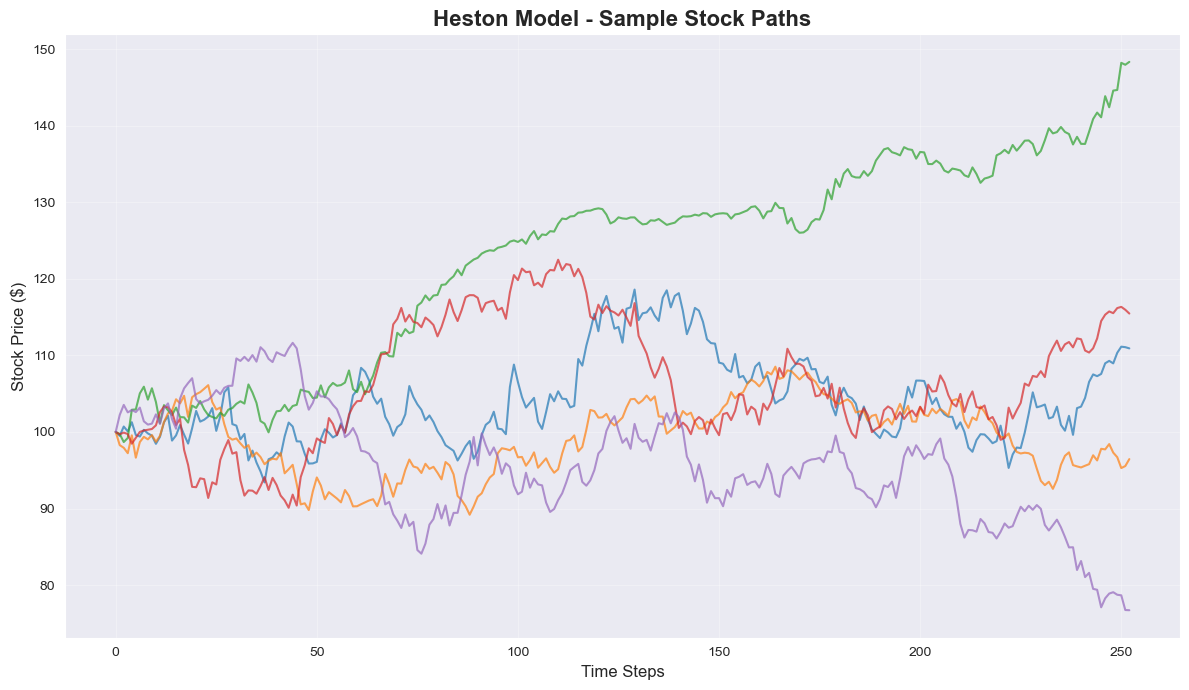

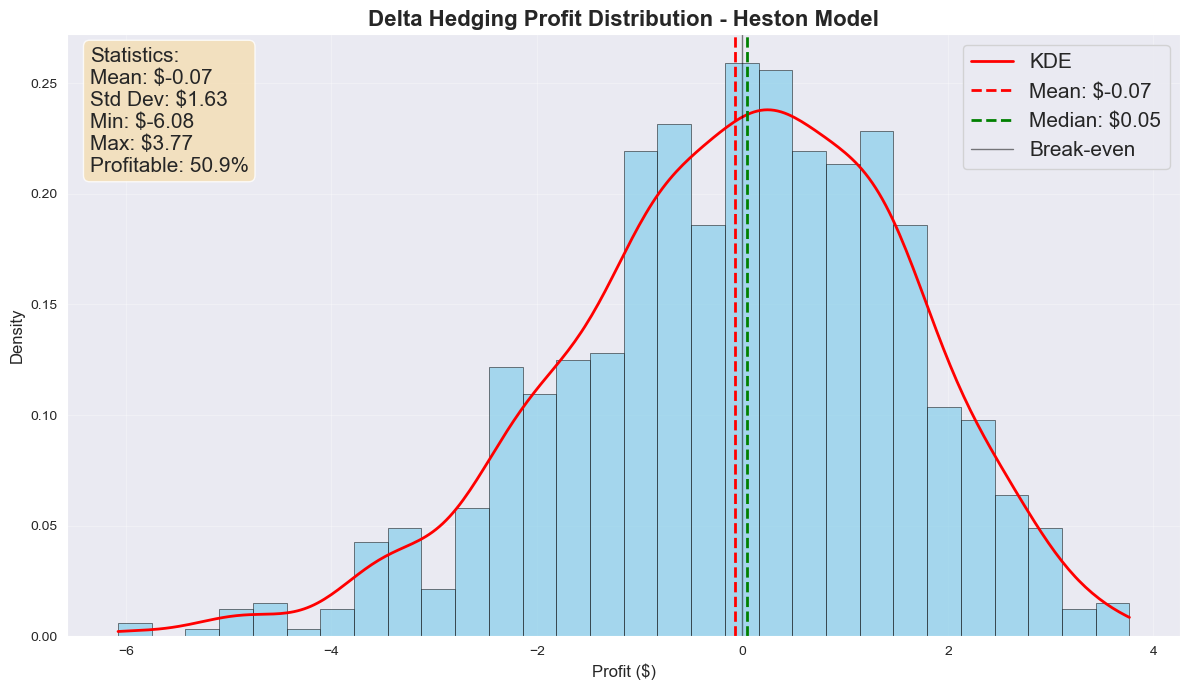

Heston Model Results:
  Mean Profit: $-0.07
  Std Deviation: $1.63
  Profitable Outcomes: 50.9%


In [7]:
print("\n3. HESTON STOCHASTIC VOLATILITY MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate Heston paths
heston_paths, heston_vols = simulate_heston_paths(
    S0=S0, v0=0.04, mu=mu, r=r, kappa=2.0, theta=0.04,
    xi=0.3, rho=-0.7, T=T, N=N, n_paths=n_paths
)

# Plot sample paths
plot_stock_paths(heston_paths, "Heston Model", n_display=5)

# Calculate hedging profits
heston_profits = delta_hedge_simulation(heston_paths, heston_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(heston_profits, "Heston Model")

print(f"Heston Model Results:")
print(f"  Mean Profit: ${np.mean(heston_profits):.2f}")
print(f"  Std Deviation: ${np.std(heston_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(heston_profits) > 0) / len(heston_profits) * 100:.1f}%")



4. SABR MODEL
----------------------------------------


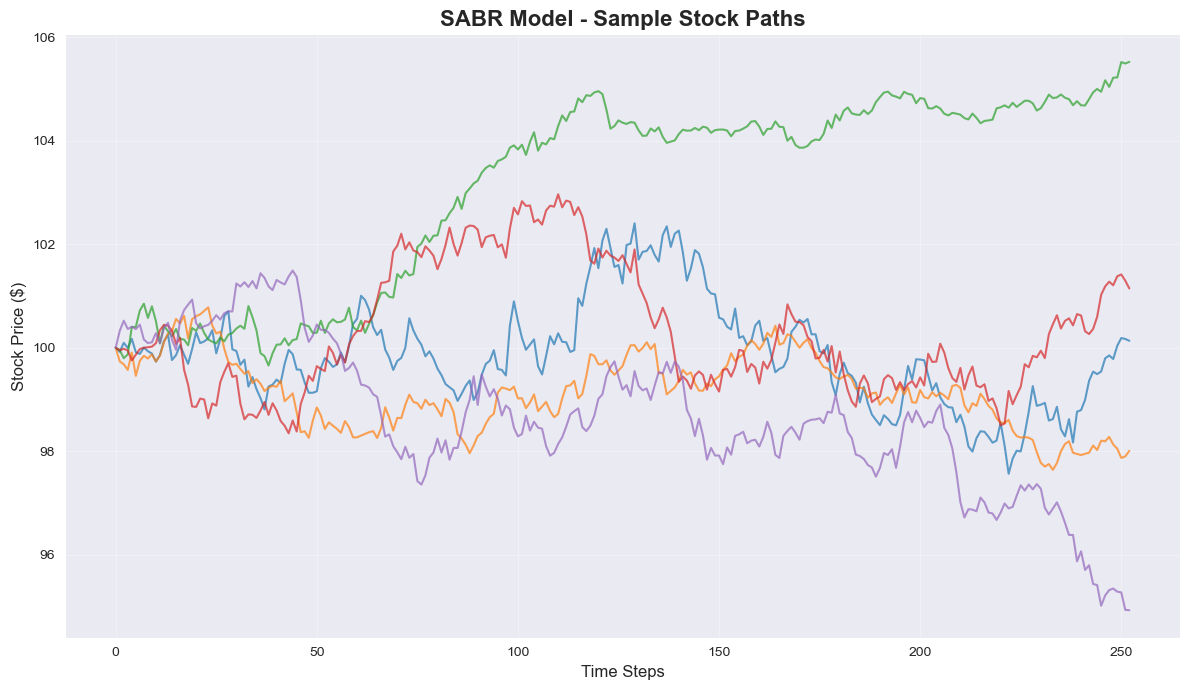

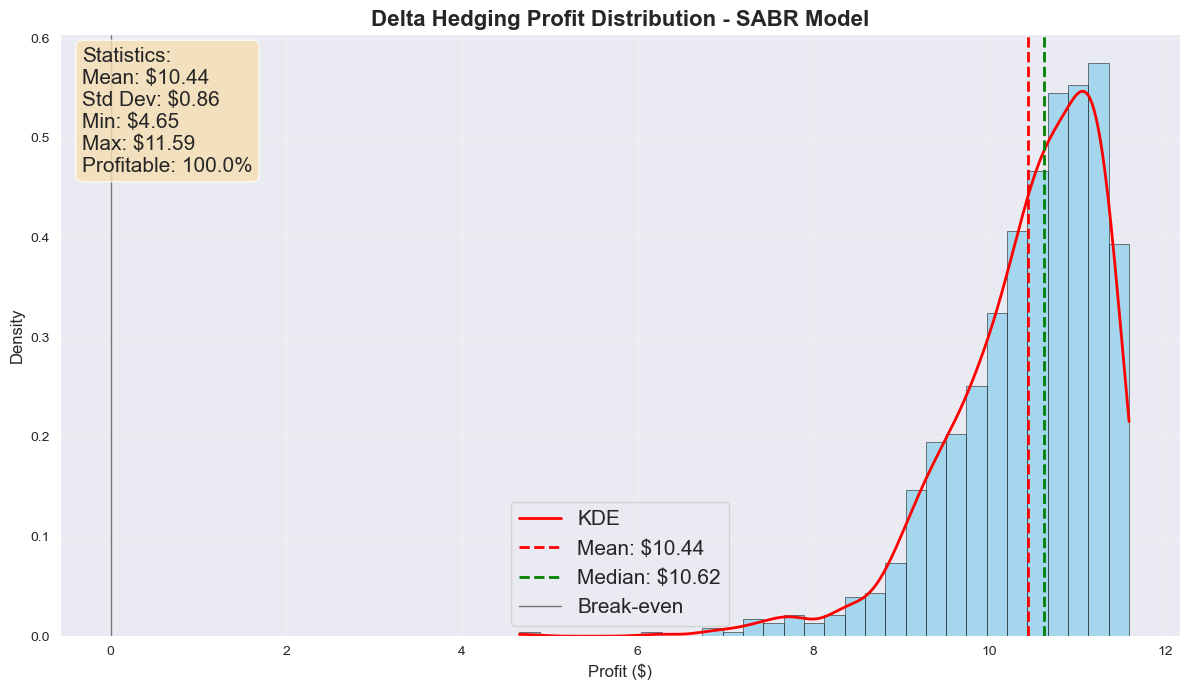

SABR Model Results:
  Mean Profit: $10.44
  Std Deviation: $0.86
  Profitable Outcomes: 100.0%


In [8]:
print("\n4. SABR MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate SABR paths
sabr_paths, sabr_vols = simulate_sabr_paths(
    F0=S0, alpha0=0.3, beta=0.5, nu=0.4, rho=-0.3, T=T, N=N, n_paths=n_paths
)

# Plot sample paths
plot_stock_paths(sabr_paths, "SABR Model", n_display=5)

# Calculate hedging profits
sabr_profits = delta_hedge_simulation(sabr_paths, sabr_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(sabr_profits, "SABR Model")

print(f"SABR Model Results:")
print(f"  Mean Profit: ${np.mean(sabr_profits):.2f}")
print(f"  Std Deviation: ${np.std(sabr_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(sabr_profits) > 0) / len(sabr_profits) * 100:.1f}%")


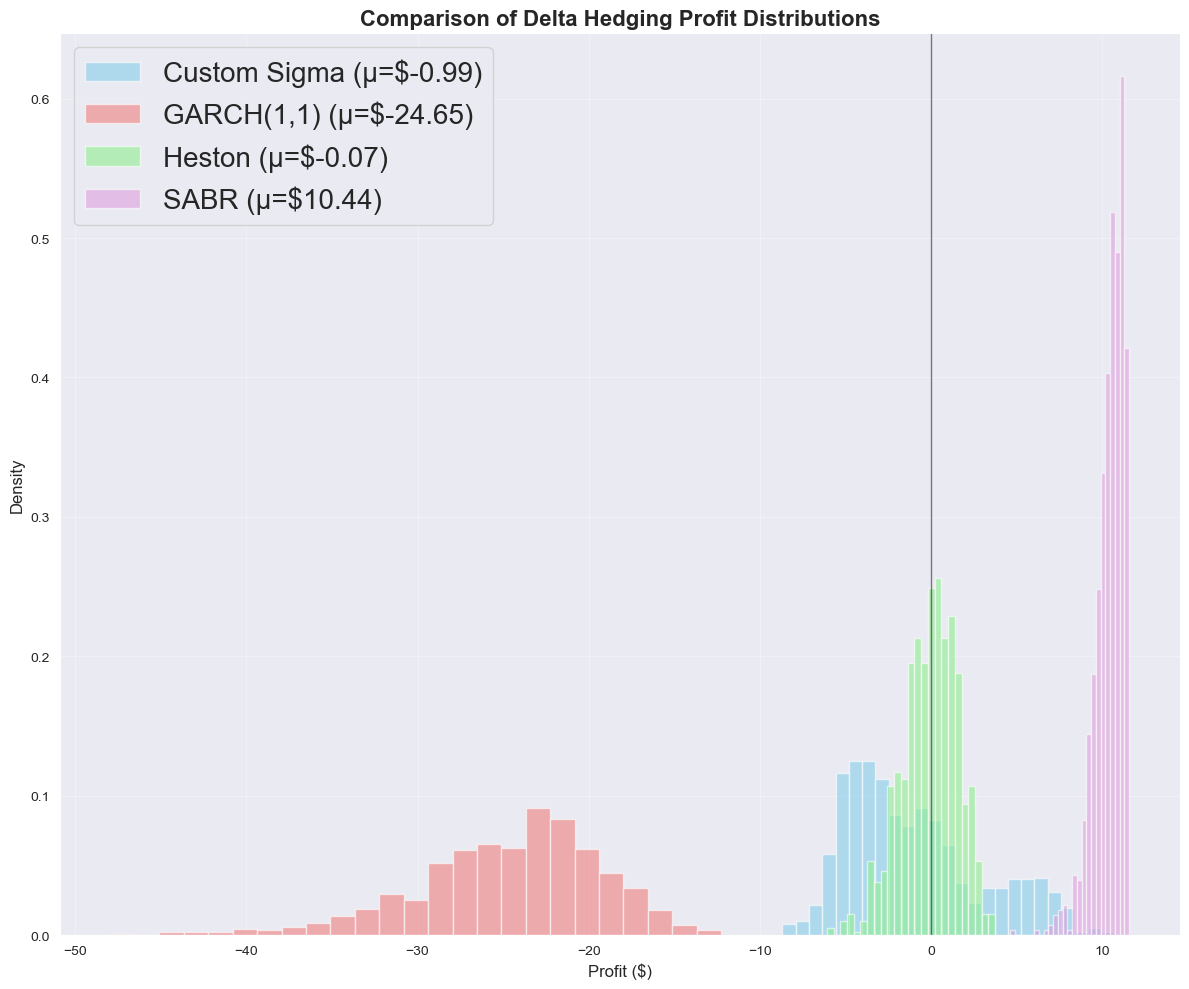

In [9]:
# Compare delta hedging profit distributions across all models
all_profits = {
    "Custom Sigma": custom_profits,
    "GARCH(1,1)": garch_profits,
    "Heston": heston_profits,
    "SABR": sabr_profits
}

compare_profit_distributions(all_profits)

## Summary and Discussion

This study evaluated the performance of **Black-Scholes delta hedging** under various **non-constant volatility models** using simulated asset paths. The results show that **none** of the stochastic volatility models could fully hedge the risk of the call option using the delta strategy alone. However, the nature of the hedging error varies by model:

### Key Observations:

- **Custom Sigma Model** (random volatility each step):
  - Most intuitive and least volatile among the four models.
  - Produced a **slightly negative average profit**, suggesting mild under-hedging.
  - Had the **highest fraction of profitable hedges**.

- **GARCH(1,1)**:
  - Exhibits **volatility clustering**, leading to more pronounced hedging errors during high-volatility episodes.
  - Lower average profits and higher standard deviation than the Custom model.
  - Demonstrated the **least hedging effectiveness**, with profits fluctuating significantly.

- **Heston Model**:
  - Introduced **mean-reverting stochastic variance**.
  - Hedging was more consistent compared to GARCH but still incurred frequent losses.
  - Profit distribution was tight but shifted negatively due to under-hedging during volatility spikes.

- **SABR Model**:
  - Common in interest rate and FX markets, adds **log-normal stochastic volatility**.
  - Generated a broad distribution of outcomes, with heavy tails and frequent large losses.
  - Profitable outcomes were relatively rare despite dynamic volatility.

### Conclusion:

The experiment highlights that **delta hedging is not sufficient** under stochastic volatility. More advanced techniques like **vega-hedging (sigma-hedging)** or **robust risk management** are necessary to deal with real-world volatility dynamics.

### Future Work:
- Implement and compare **vega-hedging strategies**
- Evaluate **transaction costs** during rebalancing
- Include **jump-diffusion** and **regime-switching** models for deeper realism
